# Multi-Armed Bandits: Exploration and Exploitation Strategies
Last Updated by Rockson Chang, 8.20.17  

## Table of Contents

**[`1.0 Introduction`](#introduction)**  

**[`2.0 The multi-armed bandit problem`](#MAB problem)**  
[`2.1 The Environment`](#environment)   
[`2.2 The Agent`](#agent)   
[`2.2.1 Value Estimation: Sample average`](#agent)   
[`2.2.2 Action Policy: Greedy and Epsilon-greedy`](#action)  
[`2.3 Implementation`](#implementation)   

**[`3.0 Exploration and exploitation strategies`](#strats)**  
[`3.1 Epsilon-greedy action selection`](#epsilon-greedy)   
[`3.2 Softmax action selection`](#softmax)   
[`3.3 Optimistic initial values`](#optimistic)  
[`3.4 Upper confidence bound action selection`](#UCB)  
[`3.5 Dynamic environments`](#dynamic)  
[`3.6 Bernoulli environments`](#bernoulli)  
[`3.6.1 Thompson sampling`](#TS)  

**[`4.0 A broader perspective`](#outro)**  
[`4.1 Considerations when choosing a MAB strategy`](#practical)   
[`4.2 Applications of MABs`](#applications)   
[`4.3 Reinforcement learning`](#RL)   
[`4.4 Further resournces`](#resources)

# 1.0 Introduction <a class="anchor" id="introduction"></a>

The mutli-armed bandit (MAB) is a conceptual problem regarding the challenge of decision making in the presence of uncertain rewards and given finite resources. A key aspect of this problem is the ability to dynamically assess the actions that are taken so to maximize the cumulative reward. Thus, the MAB problem highlights the tension that exists between exploiting a knowledge to acquire immediate reward, while maximizing the long-term reward through exploration. Although conceptually simple, this tension allows for a richness in exploration-exploitation strategies, and the problem itself can be mapped to many real-world situations such as automated A/B testing and optimization in operations research.

**Goals of this notebook**
* Provide an overview of the multi-armed bandit problem
* Demonstrate some of the different strategies through numerical experimentation
* Provide a framework for which to conduct MAB experiments
* Discuss some of the real life application of MABs

# 2.0 The multi-armed bandit problem <a class="anchor" id="MAB problem"></a>

The multi-armed bandit resembles that of a gambler who finds themself before a row of slot machines. At a given moment, the gambler may choose to play any single machine and reap a corresponding reward. Each machine potentially yields a different reward and so there is an opportunity cost associated with an incorrect action. The situation then resets, and the gambler chooses their next action. With no initial information, the gambler must devise a strategy so to maximize their cumulative reward and thereby *win* the game.

<img src="./images/multiarmedbandit.jpg" alt="Drawing" style="width: 300px;"/>
<center>**`Figure 2.0:`** `A classic multi-armed bandit.`</center>

To be concrete, at each moment in time **$t$**, each action $A_t$ results in a reward $R_t$ drawn from the **Environment** (the row of slot machines). Each reward payout provides the **Agent** (the gambler) with some additional information on the Environment. The Agent then updates their **Value Estimate** of each action, $Q_{t+1,a}$. This informs the agent's next action based on their chosen **Action Policy**, and the cycle repeats.

In the following sections, we'll see this process playout for different Bandit strategies and in different environments.

<a class="anchor" id="loop"></a>
<img src="./images/MAB_diagram_2.jpg" style="width:600; height:350;">
<center>**`Figure 2.1:`** `The MAB conceptual loop, highlighting the interplay between the Agent and the Environment.`</center>

## 2.1 The Environment <a class="anchor" id="environment"></a>

The Environment can take on many forms. The simplest is a deterministic environment, where each action results in a well-defined reward. This case has a trivial solution of necessitating just one sample of each action to identify the optimal action. Deterministic environments rarely occur in real-life scenarios. 

More common are environments where the payout is an inherently probabilistic process, with the reward drawn from an initially unknown probability distribution. Some examples include: 

* returns on investment from a stock portfolio
* conversions from different versions of an advertisement
* content recommendation based on past user preferences
* dynamic resource allocation in operations research problems

In each of these examples, the actions represent finite opportunities that may have an implicit or explicit cost, and yield rewards drawn from an initially unknown probability distribution. 

In this notebook, we'll be exploring non-deterministic environments.

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Let's start by simulating a three-armed bandit problem ($k=3$). We set the reward distribution of each arm to be drawn from a continuous normal distribution centered at 0, -1.5, and +1.5, each with standard deviation of 1. When an action is taken, a reward is drawn from the corresponding reward distribution.

In [2]:
seed = 16                  
np.random.seed(seed)       # fix this to get consistent results for presentation
k = 3                      # number of bandit arms
arm_centers = [0, -1, +1]  # mean value of each reward distribution

Let's visualize these reward distributions using a violin plot. Here, we see that while `Action 3` yields the highest reward on average, there remains a large uncertainty as to the optimal action if only a single sample is drawn.  Evidently, one must draw multiple samples and accumulate sufficient information so to make an informed decision. Traditionally, this might be done with an A/B/n test. But, as we'll see shortly, there are much more intelligent and efficient ways to do this.

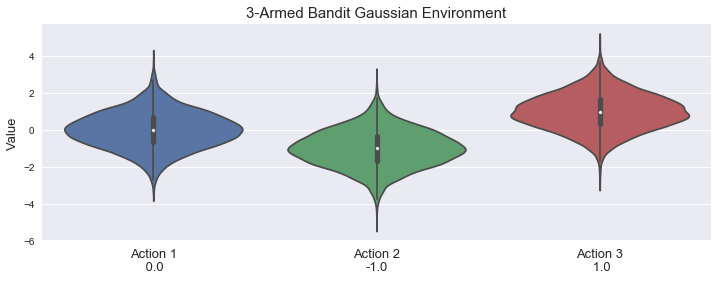

In [3]:
## sample from the environment 
N_samples = 10000
samples = np.empty([N_samples,k])
for i, center in zip(range(k), arm_centers):
    samples[:,i] = np.random.normal(loc=center, scale=1, size=N_samples)

## visualize the environment
fig, ax = plt.subplots(1, 1, figsize=(12,4))
sns.violinplot(data=pd.DataFrame(samples), ax=ax)
ax.set_xticklabels(['Action {}\n{:4.1f}'.format(i,v) for i,v in zip(range(1,k+1),arm_centers)], fontsize=13);
ax.set_ylabel('Value', fontsize=13);
ax.set_title("{}-Armed Bandit Gaussian Environment".format(k), fontsize=15);   

$\qquad\qquad\qquad$**`Figure 2.2:`** `Visualization of a 3-armed Bandit environment.`

## 2.2 The Agent <a class="anchor" id="agent"></a>
### 2.2.1 Value estimation <a class="anchor" id="value"></a>
The goal of our agent is to maximize their cumulative reward. The environment is hidden to our agent, however, each action results in a reward, which provides information on the system. The agent tracks this information through *value estimation* for each of the possible actions.   

*Maximization of the cumulative reward is usually the goal, however there are notable exceptions. See for example [Section 3.2](#softmax)</a> on softmax action selection.*


#### Sample average method estimate of value
A simple way to estimate the value of a particular action is to maintain a running average of the corresponding rewards. After $N_a$ attempts at action $a$, the value is given by

> $\large Q_{t+1}(a)=\frac{R_1+R_2+...R_{N_a}}{N_a}$

As $N_a\rightarrow\infty$, $Q_t(a)$ converges on the true reward mean.

We can express this incrementally. Given the $N^{th}$ reward $R_{N_a}$ for action $a$ with value estimate $Q_N(a)$, the new estimate is,

> $\large Q_{t+1}(a)=Q_t(a)+\frac{1}{N}\left[ R_{N_a}-Q_t(a) \right]$

Alternatively, if an action was not sampled this step, the value is not updated. In general, value estimation can be expressed as,

>#### `New Estimate` $\leftarrow$ `Old Estimate + Step Size * [ Target − Old Estimate ]`

### 2.2.2 Action selection policy <a class="anchor" id="action"></a>
With an estimate of the value of each action, the Agent must devise a strategy to maximize its cumulative rewards. The value estimation and action policy of the Agent largely determinehow succesful it will be in its goal.

#### Greedy action selection
A naive first strategy would be for the Agent to always follow the action with the highest estimated value: 

>Choose $A_t$ such that $Q_t(A_t)=max_a Q_t(a)$

This method is *greedy* in that it always chooses to exploit the knowledge of the system. While this approach yields immediate reward, it generally does not lead to the highest possible cumulative reward, since without exploration we can not be certain there is not another action with higher reward. 

#### Epsilon-greedy action selection

Instead of always exploiting the system, one could decide that a fraction $\epsilon$ of actions are devoted to choosing a random action. This random selection effects an exploration of the action space. The higher $\epsilon$, the more often exploration is conducted and the more quickly one can learn about the system. The trade-off is that while exploring, the reward gained is unlikely to be maximal.

> Let $x$ be a number drawn from a uniform probability distribution  
>> If $x<\epsilon$, choose a random $A_t$  
>> If $x>=\epsilon$, choose $A_t$ such that $Q_t(A_t)=max_a Q_t(a)$

## 2.3 Implementation <a class="anchor" id="implementation"></a>
We've created the environment ($k=3$, Gaussian reward distributions), chosen a value estimator (sample average), and set an action policy ($\epsilon$-greedy). Let's put this together and see how our agent performs.

In [4]:
## initialize agent value estimator
np.random.seed(seed)         
values = np.zeros(k)

## select action according to epsilon-greedy policy
epsilon = 0.1                
if np.random.uniform()<epsilon: 
    action = np.random.randint(0,k)
else: 
    action = np.argmax(values)   

## get reward. The reward is drawn from our environment distributions
reward = np.random.normal(loc=arm_centers[action])

## print out the results
print "Action = {}, Reward = {:0.4f}".format(action+1, reward)

Action = 1, Reward = 2.6945


Our agent has select a first action, and drawn a first reward. With this bit of information, our agent can now update its understanding of the environment.

In [5]:
## Agent sample average value estimation 
N_sampled = np.zeros(k)

## update value estimate
N_sampled[action] += 1
alpha = 1./N_sampled[action]
values[action] += alpha*(reward-values[action])

## print
print "Values = {}".format(values)

Values = [ 2.69446843  0.          0.        ]


Let's replay this cycle 100 times and see what happens

In [6]:
## initializations
np.random.seed(seed)       
epsilon   = 0.1            
N_sampled = np.zeros(k)
values    = np.zeros(k)
N_steps   = 100

## prepare a dataframe to track the agents actions
df = pd.DataFrame(columns=['Action','Reward','Q1','Q2','Q3'], index=range(N_steps))

## take 100 steps
for i in range(N_steps):

    ## select action
    if np.random.uniform()<epsilon: action = np.random.randint(0,k)
    else: action = np.argmax(values)   
    ## get reward
    reward = np.random.normal(loc=arm_centers[action])
    ## update value
    N_sampled[action] +=1
    alpha = 1./N_sampled[action]
    values[action] += alpha*(reward-values[action])
    
    ## store result
    df.loc[i] = pd.Series({'Action':action+1, 'Reward':reward, 
                           'Q1':float(values[0]), 'Q2':float(values[1]), 'Q3':float(values[2])})

df.head(10)

,Action,Reward,Q1,Q2,Q3
0,1,2.69447,2.69447,0,0
1,1,1.23099,1.96273,0,0
2,1,-0.888948,1.01217,0,0
3,1,0.49891,0.883855,0,0
4,1,0.339419,0.774967,0,0
5,1,-1.18374,0.448516,0,0
6,1,1.33321,0.5749,0,0
7,1,-0.93484,0.386183,0,0
8,3,-0.0234463,0.386183,0,-0.0234463
9,1,-0.143544,0.327324,0,-0.0234463


We've used a dataframe to store the Action, Reward, and Value history of our agent. Below we visualize this. 

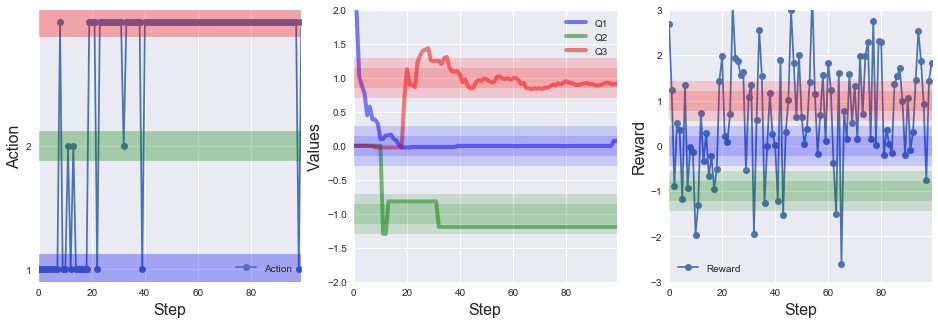

In [7]:
fig, ax = plt.subplots(1,3, figsize=(16,5))

##  Actions
df.plot(ax=ax[0], y='Action',style='o-',yticks=[0,1,2])
ax[0].set_ylabel('Action',fontsize=16)
ax[0].set_xlabel('Step',fontsize=16)

## Value Estimates
df.plot(ax=ax[1], y='Q1',style='b-',linewidth=4, alpha=0.5, ylim=[-2,2])
df.plot(ax=ax[1], y='Q2',style='g-',linewidth=4, alpha=0.5, ylim=[-2,2])
df.plot(ax=ax[1], y='Q3',style='r-',linewidth=4, alpha=0.5, ylim=[-2,2])
ax[1].set_xlabel('Step',fontsize=16);
ax[1].set_ylabel('Values',fontsize=16);

## Rewards
df.plot(ax=ax[2], y='Reward',style='o-',ylim=[-3,3])
ax[2].set_ylabel('Reward',fontsize=16)
ax[2].set_xlabel('Step',fontsize=16);

## Make things pretty
for i,a,c in zip(range(N_steps), arm_centers, 'bgr'):
    i += 1
    ax[0].plot(i*np.ones(N_steps), linewidth=30, alpha=0.3,color=c)
    ax[1].plot(a*np.ones(N_steps), linewidth=20, alpha=0.15,color=c)
    ax[1].plot(a*np.ones(N_steps), linewidth=40, alpha=0.15,color=c)
    ax[2].plot(a*np.ones(N_steps), linewidth=20, alpha=0.15,color=c)
    ax[2].plot(a*np.ones(N_steps), linewidth=40, alpha=0.15,color=c)


<center>**`Figure 2.3:`** `A 3-armed bandit experiment. Actions, value estimates, and corresponding rewards. Over the course of 100 steps, we see how our agent combines exploration and exploitation to learn about the Environment, while attempting to maximize its rewards.`</center>

In the experiment, we can see that our agent starts by choosing `Action 1`, which has average reward of 0. From time to time, it explores a random action and the value estimation updates to eventually recognize that `Action 2` has a higher mean reward around step 20. Although the agent has now landed on the optimal action, it nonetheless continues to explore the space a fraction $\epsilon$ of the time.

# 3.0 Exploration and exploitation strategies <a class="anchor" id="strats"></a>

We've now seen a first implementation of a Bandit problem where an Agent interacts with (and learns from) an environment. This simple implementation shows some of the basic properties of the MAB problem solved by an $\epsilon$-greedy strategy. In the subsequent section, we'll look in detail at the trade-offs between different Agent strategies.

To facilitate this study, we've created a class of functions that allow for the building of Bandit pipelines consisting of Environment, Agent Value Estimation, and Agent Action Policy. In addition, we have developed a series of functions to help implement and visualize these simulations. The functionalization of each of these elements makes clear how they fit together as illustrated in the [MAB loop](#loop):

* **Environment** (input: action, output: reward)
* **Agent Value Estimate** (input: reward, output: value)
* **Agent Action Policy** (input: value, output: action)

This code base has been largely inspired by Byron Galbraith's implementation (https://github.com/bgalbraith/bandits)

In [8]:
import Bandits as bd

We'll create a **5-armed bandit environment**, where the rewards are drawn from a normal distribution. For the bulk of studies in the remainder of this notebook, we'll be using this same environment.

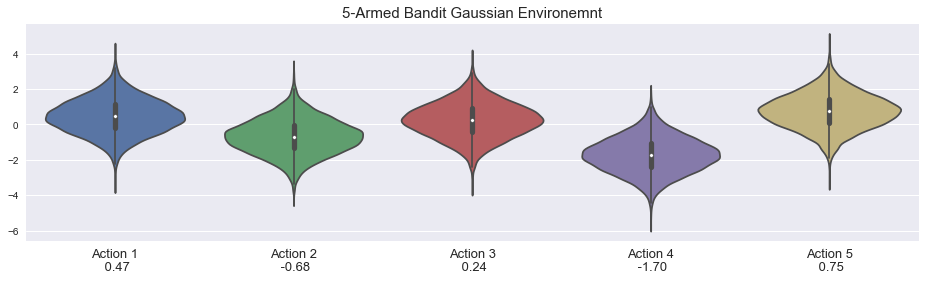

In [9]:
k, seed = 5, 12
env = bd.Env_Gaussian(k=k, seed=seed) 
env.visualize_env()

<center>**`Figure 3.0`**: `A 5-armed gaussian bandit environment. This enviornment will be used for the bulk of the MAB experiments in this notebook.`</center>

Due to the stochastic nature of Bandit problems, it is necessary to average over many simulations so to reveal the average performance. Here we'll be averaging over 500 experiments of 1000 steps each.

100%|██████████| 500/500 [00:23<00:00, 20.97it/s]


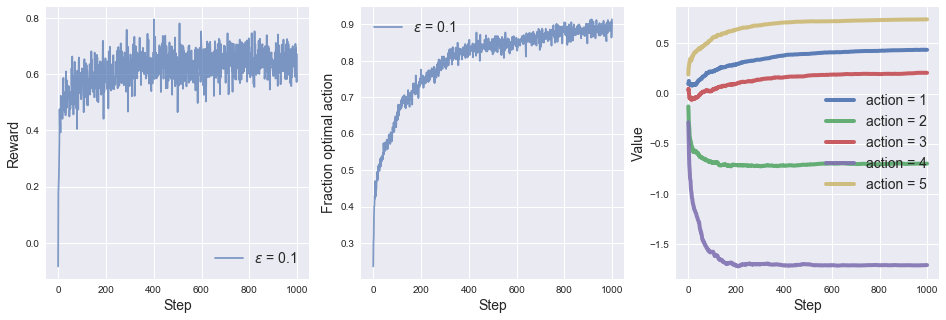

In [10]:
"""
* Environment: k=5 Gaussian Bandit
* Agent: Sample average value estimation; Epsilon-greedy action policy
"""
## Pipeline
epsilon = 0.1                
agent  = bd.Agent_SampleAverage(k=k)
policy = bd.Policy_EpsilonGreedy(k=k, epsilon=epsilon)
bandit = bd.Bandit(env, agent, policy)

## Run experiment
bandit.avg_experiment(experiment_label='$\epsilon$ = {}'.format(epsilon))    
bandit.plot(keys = ['reward','action','values'])

<center>**`Figure 3.1:`** `Average performance of an epsilon-greedy action selection and sample average value estimation Agent. Reward, fraction optimal actions, and corresponding value estimates. `</center>

Our agent uses a **sample-average value estimation** and implements an **epsilon-greedy action policy** with $\epsilon$=0.1. The above results are averaged over 500 simulations. 

We see that initially the Agent is just guessing, choosing the optimal $1/k\sim 0.2$ times. However it is able to quickly distinguish clearly positive actions from clearly negative actions, choosing the optimal action $\sim 0.4$ of the time after just a few steps. Distinguishing between the positive actions takes significantly longer as these reward distributions have large overlap. After about 200 steps, the Agent has learned enough to choose the optimal action 75% of the time. 

While the learning plateaus and the value estimations converge to the correct value, the optimal action will not exceed 90%. This is because the algorithm continues to explore $\epsilon=0.1$ of the time, even when it has converged on what it knows to be the optimal solution.

In the next section we'll see how various algoirthms behave for different exploration-exploitation tradeoffs. 

## 3.1 Epsilon greedy algorithms <a class="anchor" id="epsilon-greedy"></a>

100%|██████████| 500/500 [00:16<00:00, 29.87it/s]


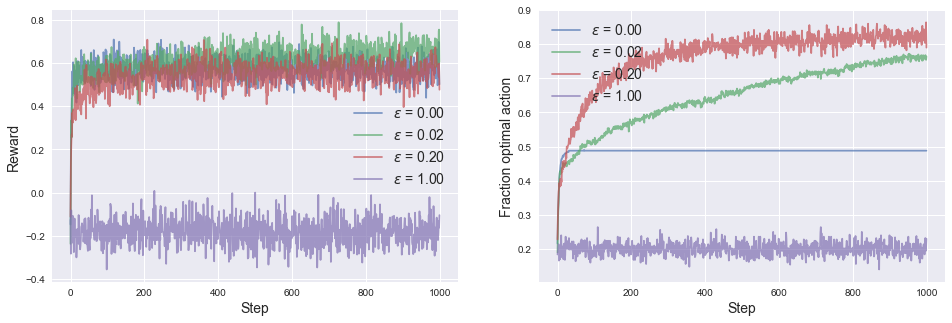

In [11]:
"""
* Environment: k=5 Gaussian Bandit
* Agent: Sample average value estimation; Epsilon-greedy action policy for different epsilons
"""
## Pipeline
epsilon_list = [0.0, 0.02, 0.20, 1.0]   
agent  = bd.Agent_SampleAverage(k=k)
policy = bd.Policy_EpsilonGreedy(k=k)
bandit = bd.Bandit(env, agent, policy)

## Run experiments
for epsilon in epsilon_list:
    bandit.policy.__init__(k=k, epsilon=epsilon)
    bandit.avg_experiment(experiment_label='$\epsilon$ = {:3.2f}'.format(epsilon))  
bandit.plot(keys = ['reward','action'])

<center>**`Figure 3.2:`** `Performance of various Epsilon-greedy strategies.`</center>

* A purely exploratory strategy ($\epsilon=1.0$) randomly samples each action, and so will never land on the optimal action more than $1/k$ of the time. 
* A more moderate strategy ($\epsilon=0.20$) quickly finds the optimal, but saturates at an optimal action rate of $1-\epsilon$.
* The greedier strategy ($\epsilon=0.02$) slowly approaches the optimal, but wlll eventually saturate at a higher optimal action rate.
* Lastly, a greedy strategy ($\epsilon=0$) is able to learn initially due to the stochastic nature of the sampling process. However it quickly latches onto the action that yield the largest reward in the initial sampling. This is often the incorrect action as it has not allowed for continued exploration to ensure sufficiently robust statistics.

As we can see, a balanced approach is required to quickly find the optimal action, while not sacrificing too much in cumulative reward.

## 3.2 Softmax action selection <a class="anchor" id="softmax"></a>

During exploration, the $\epsilon$-greedy approach explores all options with an equal probability, regardless of knowledge of their values. This can be problematic, particularly in situations where sub-optimal actions lead to unacceptable negative consequences, for example:

* side-effects during medical drug trials 
* inadvertant recommendation of offensive in inappropriate content 
* purchase of costly, high-risk stocks

The softmax approach seeks to perform a smarter exploration by disfavouring negative outcomes. It does this by selecting actions based on a weighted probability distribution, where weights are derived from current value estimates. A most common weighting scheme uses a Gibbs distribtion.

> Let $a$ be a random action drawn from a weighted probability distribution with weights,  
> 
> $\large P_t(a)=\frac{\exp(Q_t(a)/\tau)}{\sum_a \exp(Q_t(a)/\tau)}$
>> Choose $A_t$ such that $A_t= a$

The parameter $\tau$ is the *temperature* of the system. Higher temperatures favor a more random selection, lower temperatures favor a heavily-weighted approach.

100%|██████████| 500/500 [00:13<00:00, 37.77it/s]


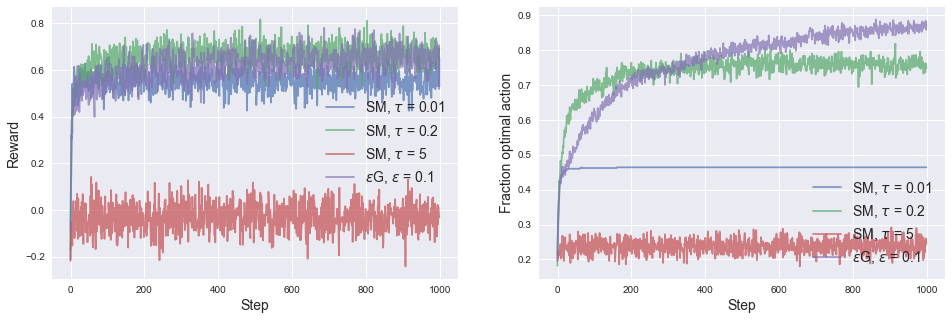

In [12]:
"""
* Environment: k=5 Gaussian Bandit
* Agent: Sample average value estimation; Softmax vs Epsilon-greedy action selection policy
"""
## Pipeline
tau_list = [0.01, 0.2, 5]     # Gibbs ensemble temperatures
epsilon  = 0.1
agent  = bd.Agent_SampleAverage(k=k)
policy = bd.Policy_Softmax(k=k)
bandit = bd.Bandit(env, agent, policy)

## Run experiment -- Softmax
for tau in tau_list:
    bandit.policy.__init__(k=k, tau=tau)
    bandit.avg_experiment(experiment_label='SM, $\\tau$ = {}'.format(tau))
# Run experiment -- Epsilon greedy
bandit.policy = bd.Policy_EpsilonGreedy(k=k, epsilon=epsilon)
bandit.avg_experiment(experiment_label='$\epsilon$G, $\epsilon$ = {}'.format(epsilon))

bandit.plot(keys = ['reward','action'])

<center>**`Figure 3.3:`** Performance of the softmax action selection for various temperatures. For contrast, an epsilon-greedy strategy is also shown ($\epsilon=0.1$).</center>

Above we see how softmax action selection behaves for different temperatures, and in contrast to an epsilon-greedy approach.

* For low-temperatures ($\tau=0.01$) the selection resembles that of a greedy strategy ($\epsilon\rightarrow0$), which is unable to consistently identify the optimal solution.
* For high-temperatures ($\tau=5$), each selection is equally likely during exploration and thus resembles purely exploratory approach ($\epsilon\rightarrow1$) which uniformly samples all actions.
* For intermediate temperatures (here, $\tau=0.2$), softmax we see qualitatively similar performance to that of epsilon-greedy. 

Here, epsilon-greedy seems to out-perform the softmax action selection in terms of identifying the action that yields highest reward. However, the real advantage of softmax action selection is to suppress the selection of negative outcomes. 

We see this explicity below, where we tabulate the cumulative fraction of times each action is performed, for each of the above strategies. While both strategies successfully identify `Action 5` to yield the highest reward and samples it most often, the softmax action selection ($\tau=0.2$) dramatically suppresses the rate at which actions with negative outcomes (`Actions 2` and `4`) are sampled.

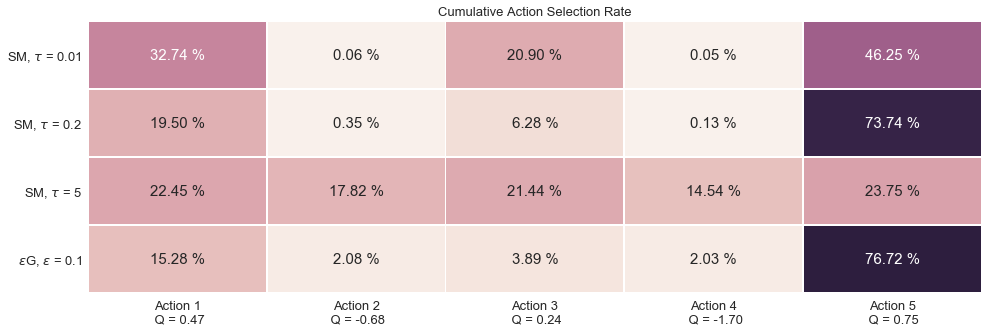

In [13]:
bandit.plot(keys = ['regret'])

<center>**`Figure 3.4:`** Cumulative action selection rate for softmax and epsilon-greedy action selection.</center>

## 3.3 Optimistic initial values <a class="anchor" id="optimistic"></a>
Coming back to the $\epsilon$-greedy approach we see that there are macro trade-offs to a given exploration-exploitation strategy. A strategy with high exploration (large $\epsilon$)  will converge on the correct answer quickly, but will lose out to a more exploitive strategy (small $\epsilon$) in the long-term as it continues to explore.

An adaptive strategy, that varies the rate of exploration as it learns, would thus perform better in such situations where the environment is static. One simple way to acheive this is to set optimistic initial values. This forces the system to test out each arm at least once at the very beginning and rapidly learn. This is effecitvely like starting with pure exploration for a few initial steps, followed by an $\epsilon$-greedy approach.

100%|██████████| 500/500 [00:25<00:00, 19.89it/s]


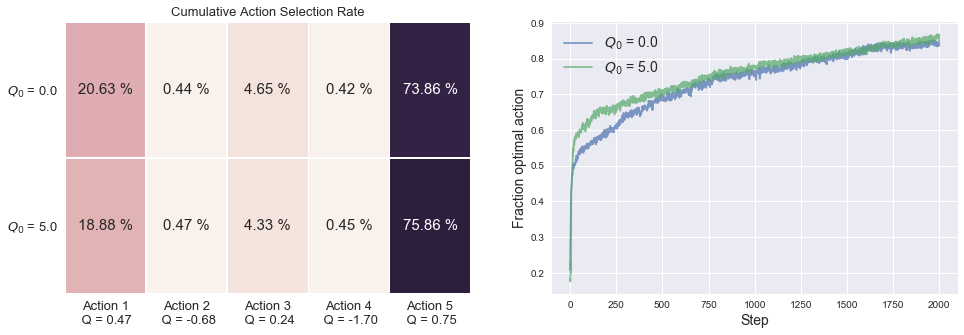

In [14]:
"""
* Environment: k=5 Gaussian Bandit
* Agent: Sample average value estimation with optimistic initial values; Epsilon-greedy action policy
"""
## Pipeline
init_values_arr = [0.0, 5.0]
epsilon         = 0.02   
agent  = bd.Agent_SampleAverage(k=k)
policy = bd.Policy_EpsilonGreedy(k=k)
bandit = bd.Bandit(env, agent, policy)

## Run experiment
for init_values in init_values_arr:
    bandit.agent.__init__(k=k, init_values=init_values)
    bandit.policy.__init__(k=k, epsilon=epsilon)
    bandit.avg_experiment(Nsteps=2000, experiment_label='$Q_0$ = {:1.1f}'.format(init_values))    
bandit.plot(keys = ['regret','action'])

<center>**`Figure 3.5:`**Optimistic initial values for an epsilon-greedy strategy.</center>

Above we compare two $\epsilon$-greedy strategies, with and without optimistic initial values. While both eventually converge to the same optimal action selection rate, the one optimistic initially values does so significantly faster. Note that the chosen initial values are much larger than any of the actual rewards.

## 3.4 Upper Confidence Bound action policy <a class="anchor" id="UCB"></a>

In the spirit of an adaptive exploration strategy, the upper confidence bound (UCB) approach mixes value-based exploitation and exploration based on the Agent's confidence in those value estimates. This approach is often referred to as **optimism in the face of uncertainity**. In particular, the `UCB1` algorithm is:

> Define the upper confidence bound estimate for action $a$ at time step $t$,  
> $\large UCB_t(a) = Q_{t,a;\,sample\, avg} + \left[\frac{\log{\left(t+1\right)}}{N_{a}}\right]^{1/c} $  
>
> where $Q_{t,a;\,sample\, avg}$ is the sample average estimate of action $a$, and $N_a$ is the number of times action $a$ has been sampled. $c$ is a parmater that depends on the type of environment. For a Gaussian Bandit environemnt, $c=2$.
 
 
>> Choose $A_t$ such that $UCB_t(A_t)=max_a UCB_t(a)$  

The first term in $UCB$ tracks the Agent's estimate of the mean reward for each action. The second term is roughly the inverse fraction of times we've sampled that action. The intuition here is that if we've sampled a particular action relatively often, our confidence in the corresponding value estimate is high, and vice versa for actions infrequently sampled. The mix of mean value and confidence estimation leads to exploration within reason. 

UCB is one of the most popular MAB action policies, as it has been shown to have fast convergence and is relatively simple to implement. We see below that `UCB1` easily out-performs $\epsilon$-greedy.

100%|██████████| 500/500 [01:06<00:00,  8.37it/s]


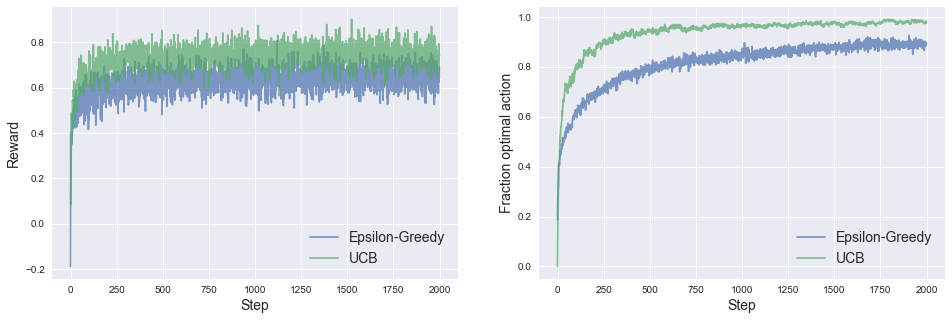

In [15]:
"""
* Environment: k=5 Gaussian Bandit
* Agent: Sample average value estimation; Epsilon-greedy action policy vs UCB policy
"""
## Pipeline
experiment_label_list = ['Epsilon-Greedy', 'UCB']
agent    = bd.Agent_SampleAverage(k=k)
policies = [bd.Policy_EpsilonGreedy(k=k, epsilon=0.1), bd.Policy_UCB(k=k, c=2.0)]
bandit   = bd.Bandit(env, agent, policies[0])

## Run experiment
for policy, experiment_label in zip(policies,experiment_label_list):
    bandit.policy = policy
    bandit.avg_experiment(Nsteps=2000, experiment_label=experiment_label)    
bandit.plot(keys = ['reward','action'])

<center>**`Figure 3.6:`** Upper confidence bound and epsilon-greedy action policies. Both policies use sample average value estimation.</center>

## 3.5 Dynamic Environments <a class="anchor" id="dynamic"></a>
Thus far, we have assumed that the environment is stationary with fixed reward distributions. In practice, we may encounter non-stationary environments, for example in article recommendation (see Contextual bandits) where user tastes may evolve over time. 

Each of the action policies we've studied above allows for the continued exploration of the environment necessary to follow potential dynamics in the environment. However, the sample average value estimation imposes limitations.

Recall, the sample average value estimation:
> $\large Q_{t+1}(a)=Q_t+\alpha\left[ R_t-Q_t(a) \right]$

where $\alpha=1/N_a$ is the step size parameter. This parameter controls the rate at which we update our value estimates. A drawback of this sample average method is that it places greater weight on early rewards than on later rewards. This can make our agent slow to adapt to changes that may occur in the environment. 

An alternative approach is to set a constant step size parameter, $0<\alpha<1$. In this form, we can rewrite our update rule as

> $\large Q_{t+1}(a) = (1-\alpha)^tQ_0(a)+\sum_{i=1}^{t}\alpha(1-\alpha)^{t-i}R_i$

Past rewards are thus discounted exponentially based on how long ago they were observed according to the weighting factor $(1-\alpha)^{t-i}$. This is referred to as exponential, recency average value estimation. 

## 3.6 Bernoulli Environments <a class="anchor" id="bernoulli"></a>

Multi-armed bandit problems commonly occur in scenarios where the reward is binary - either *success* or *failure*. A few examples of this are
* in digital advertising, where success is having a user clicking on the ad
* testing website landing page variants, where success is having a user deciding to enter the website and learn more
* content recommendation, where success is having a user follow a given link

Such situations are described by a Bernoulli trial, in which the reward for action $k$ is drawn from a Bernoulli distribution with success probability $p_k$. 

In this section, we will create such an environment and see how our various Bandit strategies fare. 

We'll create a **3-armed bandit environment**, with each arm having a success probability somewhere between 0 and 20% to simulate a typical conversion scenario. Below we visualize this environment below by plotting the distirbution of success rates after a series of 1000 Bernoulli trials. 

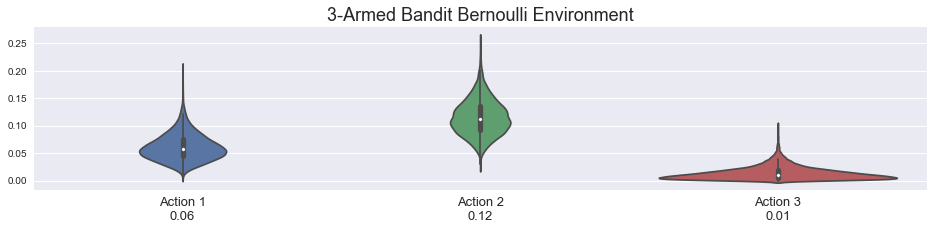

In [16]:
k, seed = 3, 21
env = bd.Env_Bernoulli(k, seed)
env.visualize_env()

<center>**`Figure 3.7:`** Visualization of a 3-armed Bernoulli environment. Distribution of success rates after a series of 1000 Bernoulli trials.</center>

### 3.6.1 Thompson Sampling <a class="anchor" id="TS"></a>

Thompson Sampling is one of the most popular Bandit strategies for Bernoulli environments. This technique, also known as a Bayesian Bandit, models the Agent's knowledge of the Environment through the use of continuous probability distributions over possible success probabilities. After each step, the prior knowledge of the environment is updated with the most recent result (success or failure) to create a posterior distribution. The posterior is then sampled and the action yielding the highest success rate is chosen.

Specifically, since we are dealing with a Bernoulli likelihood function, we model the prior and posterior with a Beta distribution Beta$(\alpha, \beta)$. In this context, $\alpha$ and $\beta$ are the number of success and failures, respecitvely. 


> Let the **likelihood function** $P_a(r | \theta)$ be the Bernoulli distirubtion with trial outcome $r$ and $\theta$ the set of parameters that define the reward distribution ($p_k$) for each action $a$.   

> Let the **prior** $P_a(\theta)$ be the Beta function Beta$(\alpha,\beta)$

> The **posterior** $P_a(\theta | r ) = P_a(r | \theta)\cdot P_a(\theta)$, is then also given by a Beta function Beta$(\alpha^\prime,\beta^\prime)$  
> where $\begin{cases} 
\alpha^\prime=\alpha+1\quad        \text{and} \quad \beta^\prime=\beta  \qquad\,\,\, \text{if $r$ was a success}  \\
\alpha^\prime=\alpha  \qquad\,\,\, \text{and} \quad \beta^\prime=\beta+1\quad        \text{if $r$ was a failure}
\end{cases}  $


> Let $x$ be a sample from the posterior for each action $a$.
>> Choose $A_t$ such that $A_t=argmax(x)_a$

Initially, we have no information on the environment and so the initial prior is assumed to be Beta$(1,1)$ (a uniform probability distribution). 

100%|██████████| 1/1 [00:00<00:00,  4.16it/s]


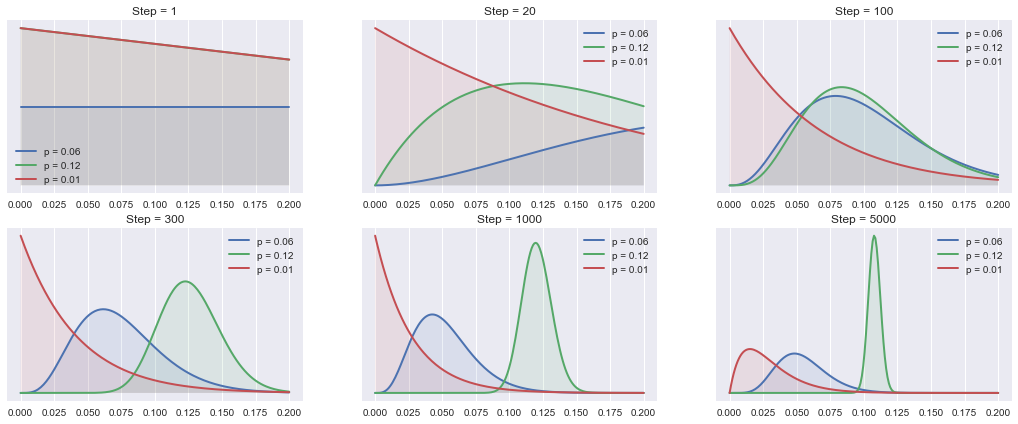

In [17]:
"""
* Environment: k=3 Bernoulli Bandit environment
* Agent: Thompson Sampling value estimation and action selection
"""
## Pipeline
Nsteps, Nruns = 5001, 1
agent  = bd.Agent_ThompsonSampling(k=k)
policy = bd.Policy_ThompsonSampling(k=k)

## Run experiment
bandit=bd.Bandit_Bernoulli(env, agent, policy)
bandit.avg_experiment(Nruns, Nsteps, experiment_label='Thompson Sampling')  
bandit.plot_beta(plot_steps=[1,20,100,300,1000,5000])

<center>**`Figure 3.8:`** Thompson sampling. Evolution of posterior distribution over the course of an experiment.</center>

Above we see the progression and updating of the belief estimation of each action over the course of a single run, through five-thousand steps. Similar to the UCB action policy, Thomspon Sampling balances exploration and exploitation by tracking not just a value estimate of the mean reward of each action, but also the confidence in that estimation. As the Agent learns more information from the Environment, the posterior distributions become more sharply defined around the true average reward. 

Next, we'll see the averaged performance of a Thompson Sampling strategy in contrast to other common action policies.

100%|██████████| 500/500 [01:57<00:00,  4.36it/s]


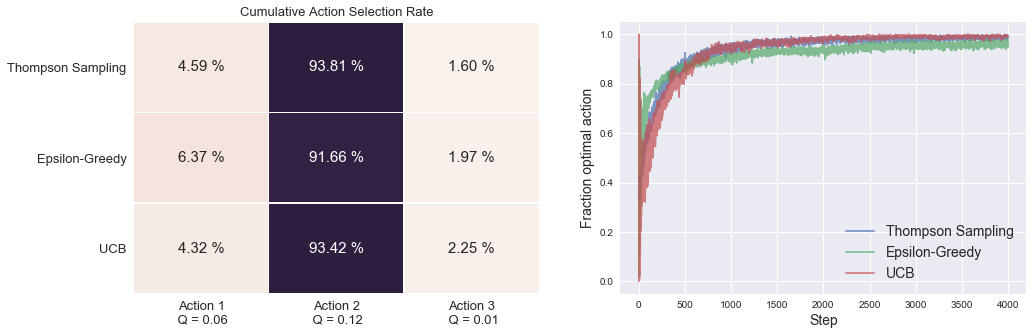

In [18]:
"""
* Environment: k=3 Bernoulli Bandit environment
* Agent: Thompson Sampling value estimation; epsilon-greedy action selection
"""
## Pipeline
epsilon = 0.05
experiment_label_list =['Thompson Sampling','Epsilon-Greedy','UCB']
agent    = bd.Agent_ThompsonSampling(k=k)
policies = [
    bd.Policy_ThompsonSampling(k=k), 
    bd.Policy_EpsilonGreedy(k=k, epsilon=epsilon), 
    bd.Policy_UCB(k=k, c=1)
           ]
bandit   = bd.Bandit_Bernoulli(env, agent, policy=None)

## Run experiment
for policy, experiment_label in zip(policies, experiment_label_list):
    bandit.policy = policy
    bandit.avg_experiment(Nsteps=4000, experiment_label=experiment_label)    
bandit.plot(keys=['regret', 'action'])

<center>**`Figure 3.9:`** Comparsion of several MAB strategies on a Bernoulli environment.</center>

Above we compare several different Bandit strategies in a Bernoulli environment. $\epsilon$-greedy learns quickly, but clearly lags behind UCB and Thompson sampling in the long run. Thompson sampling and UCB exhibit very similar assymptotic performance.

# 4.0 Some final remarks <a class="anchor" id="outro"></a>

## 4.1 Considerations when choosing a MAB strategy <a class="anchor" id="practical"></a>

We have provided an overview of several common Agent strategies. There is a fair amount of literature dedicated to deriving rigorous mathematical bounds on optimilatiity of these approaches for different situations. However, in practice, choosing between these different approaches can be quite challenging.

**From an optimization point-of-view**, 
* Do you value fast convergence or a low assymptotic error? 
* Do you value optimal action selection over avoiding negative rewards?

**From an Environment point-of-view**,
*  How much do you know about the nature of the Environment? What is the nature of the probability distribution from which rewards are drawn? 
* What is the overlap in the distributions for different actions? 
* Is the environment stationary, or do the parameters of it change over time?

## 4.2 Applications of MABs <a class="anchor" id="applications"></a>
* Ad serving and website optimization (conversion)
* Clinical trials
* Financial portfolio design
* Content recommendation (contextual bandits; see Li et al.)
* Dynamic resource allocation in operations research problems

## 4.3 Reinforcement learning <a class="anchor" id="RL"></a>
In a broader context, the MAB is a simplified version of a reinforcement learning (RL) problem. RL problems can be broadly summarized as the challenge of decision making under uncertainty. Recently, RL has gained much interest for the advances they've made in automated control (drones, self-driving cars) and games (AlphaGo). The main difference between MABs and RL is that an MAB agent does not affect the environment, whereas, in general an RL agent does. This distinction leads to significantly more complex action-state scenarios. Nonetheless, many of the concepts and trade-offs seen in the MAB problem remain relevant.

<img src="./images/RL_diagram.png" style="width:750; height:500;">
<center>**`Figure 4.0:`** The reinforcement learning conceptual loop. From Sutton & Barto.</center>

#### Reinforcement learning vs. supervised learning and unsupervised learning
In supervised learning the machine is trained on data labelled as *right* or *wrong*, and there is a clear correct choice. In unsupervised learning, the machine is tasked with discovering the underlying structure on its own with no awareness of labels. Reinforcement learning and MAB problems are distinct from both these paradigms in that rewards are only labelled as *better* or *worse* -- the machine is tasked with identifying first what the underlying structure is, and second with assessing the optimal choice.

## 4.4 Further resources <a class="anchor" id="resources"></a>

* Chapter 2 of Sutton & Barto: https://webdocs.cs.ualberta.ca/~sutton/book/the-book.html.
* Byron Galbraith's MAB framework: https://github.com/bgalbraith/bandits
* Brian Farris's MAB and RL talk: https://github.com/brianfarris/RLtalk/blob/master/RLtalk.ipynb
* Contextual Bandits at Yahoo: http://research.cs.rutgers.edu/~lihong/pub/Li10Contextual.pdf
* David Silver's RL course: https://www.youtube.com/watch?v=2pWv7GOvuf0